# Training Models

## Imports

### Modules

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import bokeh
!pip install umap-learn
import umap
!pip install umap-learn[plot]
import umap.plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 7.3 MB/s 
     |████████████████████████████████| 1.1 MB 50.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=9e8f049366650175321c4805666b9cf14ba2a0f13afb2bff069bd4a1c67e8a45
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=4a77d52adbd80db5e6fe6d296a5a3aabf15e88dee89ea3f872cbf83361de06d8
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.2 MB 757 kB/s 
     |████████████████████████████████| 76 kB 5.1 MB/s 


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Conv2D, Conv2DTranspose, Dense, Reshape, Flatten, Cropping2D,\
RandomFlip, RandomRotation, RandomCrop, RandomTranslation, Concatenate, MaxPooling2D as MP, SpatialDropout2D as SP2, Dropout
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 8s (54.3 MB/s)
(Reading database ... 155676 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155654 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+c

### Loading Images

In [4]:
fl = np.load('./downloading_data/images.npz')
imgs = fl['imgs']
ids = fl['ids']

---
## Training Model

### Model Architecture

Model: "augmentor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 5)]       0         
                                                                 
 random_crop (RandomCrop)    (None, 24, 24, 5)         0         
                                                                 
 random_flip (RandomFlip)    (None, 24, 24, 5)         0         
                                                                 
 random_translation (RandomT  (None, 24, 24, 5)        0         
 ranslation)                                                     
                                                                 
 random_rotation (RandomRota  (None, 24, 24, 5)        0         
 tion)                                                           
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params:

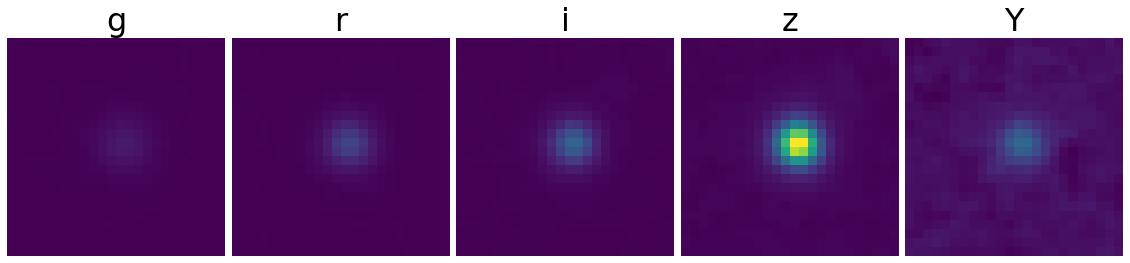

In [8]:
# Augmentor
translate_px = 2 # Number of pixels by which the images may be translated
input_images = Input(shape=(28,28,5), name='input')
x = RandomCrop(24,24)(input_images)                     # Random crop to 24*24 shape
x = RandomFlip()(x)                                     # Random flip
x = RandomTranslation(translate_px/24, translate_px/24, # Random shift
                      fill_mode='wrap')(x)
augmented_images = RandomRotation(.5)(x)                # Random rotation
augmentor = Model(input_images, augmented_images,
                 name='augmentor')
augmentor.summary()

# Encoder Base, with inputs randomly cropped to shape (24,24,5)
augmented_images = Input(shape=(24,24,5), name='augmented_input')
x = Conv2D(256, 5, activation='relu',           # A series of Convolutional and Pooling layers
           name='Conv2D_0')(augmented_images)
x = MP(pool_size=2)(x)
x = Conv2D(512, 3, activation='relu',
           name='Conv2D_1')(x)
x = MP(pool_size=2)(x)
x = Conv2D(1024, 3, activation='relu',
           name='Conv2D_2')(x)
x = MP(pool_size=2)(x)
features = Reshape((1024,),
                   name='Reshape')(x)           # The result is a 1024-dimensional vector
encoder = Model(augmented_images, features,
               name='encoder')
encoder.summary()

# Projection Head - only used in training
features = Input(shape=(1024,), name='features')
x = Dense(512, activation='relu',
          name='Dense_0')(features)
x = Dense(128, activation='relu',
          name='Dense_1')(x)
projection = Dense(64,
                   name='Dense_2')(x)
projector = Model(features, projection,
                 name='projector')
projector.summary()

### Compiling Model

#### Functions to normalise the images, and to calculate the loss function

In [ ]:
def normalise_imgs(imgs, setting=3):
    import numpy as np
    if setting==0:
        # Global normalisation to the range [0,1]
        nimgs = imgs - np.min(imgs) # Now lowest value is 0, max is like 1e5
        nimgs /= np.max(nimgs) # Now in range [0,1]

    elif setting==1: # Bandwise normalisation
        nimgs = imgs / np.max(imgs, axis=(0,1,2))

    elif setting==2: # Gaussian normalisation
        nimgs = imgs - np.mean(imgs, axis=0) # Subtracting 'mean' object
        nimgs /= np.std(nimgs, axis=0) # Dividing by 'std' object

    elif setting==3: # Object-wise normalisation - recommended
        nimgs = imgs / np.max(imgs, axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis]
    
    return nimgs

@tf.function
def contrastive_loss(mini_batch, temp=0.027): # Minibatch(i) has shape (batch_size*2, projection_dim)
    batch_size = tf.shape(mini_batch)[0] // 2 # Should be an integer anyway
    normed_mini_batch, _ = tf.linalg.normalize(mini_batch, axis=1)
    boltz_mat = boltz_matrix(normed_mini_batch, temp=temp)
    positive_boltzs = tf.linalg.diag_part(tf.roll(boltz_mat,batch_size, 0))
    boltz_norms = tf.math.reduce_sum(boltz_mat, axis=0)
    return tf.math.reduce_mean(
        -tf.math.log(tf.math.divide(positive_boltzs, boltz_norms))
    )
        
@tf.function
def boltz_matrix(normed_mini_batch, temp=0.027):
#     Returns a (2*batch_size, 2*batch_size) tensor of values B_ij = exp(sim(z_i, z_j)/temp) if i!=j, 0 if i==j
    raw_bm =  tf.math.exp(
        tf.linalg.matmul(normed_mini_batch, normed_mini_batch, transpose_b=True) / temp
    )
    return tf.linalg.set_diag(raw_bm, tf.zeros_like(normed_mini_batch[:,0]))

In [ ]:
class Contrastor(Model): # Model class for a contrastive neural network
    def __init__(self, augmentor, encoder, projector, temperature=0.027, **kwargs):
        super().__init__(**kwargs)
        self.augmentor=augmentor  # The data augmentation module
        self.encoder=encoder      # The convolutional feature encoder base
        self.projector=projector  # The projection head (used only in training)
        self.loss_tracker = tf.keras.metrics.Mean(name='contrastive loss') # Constrastive Loss tracker
        self.temperature = temperature # Temperature - a parameter in the contrastive loss (rec: 0.027)

    @property
    def metrics(self):
        return [self.loss_tracker]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            projection1 = self.projector(self.encoder(self.augmentor(data))) # Make two alterations of each batch image
            projection2 = self.projector(self.encoder(self.augmentor(data)))
            mini_batch = Concatenate(axis=0)([projection1, projection2]) # Package them together
            
            cl = contrastive_loss(mini_batch, temp=self.temperature) # Calculate the loss on the batch

        grads = tape.gradient(cl, self.trainable_weights) 
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights)) # Change the weights to reduce the loss next time
        
        self.loss_tracker.update_state(cl) # Update the loss
        return{'loss': self.loss_tracker.result()}

grizY_contr = Contrastor(augmentor, encoder, projector, temperature=.027) # Instantiating a model
grizY_contr.compile(optimizer=RMSprop(learning_rate=1e-4),
                run_eagerly=True) # I forgot what this does

callbacks_list = [
    EarlyStopping(monitor='loss', mode='min', patience=3,
                 verbose=1)
]

In [ ]:
history = grizY_contr.fit(normalise_imgs(imgs, setting=3),
               epochs=100, batch_size=64,
               callbacks=callbacks_list)

Epoch 1/100
43/43 [==============================] - 4s 93ms/step - loss: 3.5689
Epoch 2/100
43/43 [==============================] - 4s 85ms/step - loss: 1.2443
Epoch 3/100
43/43 [==============================] - 4s 87ms/step - loss: 0.6611
Epoch 4/100
43/43 [==============================] - 4s 88ms/step - loss: 0.4906
Epoch 5/100
43/43 [==============================] - 4s 86ms/step - loss: 0.3576
Epoch 6/100
43/43 [==============================] - 4s 87ms/step - loss: 0.2503
Epoch 7/100
43/43 [==============================] - 4s 87ms/step - loss: 0.2122
Epoch 8/100
43/43 [==============================] - 4s 88ms/step - loss: 0.1871
Epoch 9/100
43/43 [==============================] - 4s 86ms/step - loss: 0.1776
Epoch 10/100
43/43 [==============================] - 4s 86ms/step - loss: 0.1261
Epoch 11/100
43/43 [==============================] - 4s 85ms/step - loss: 0.1204
Epoch 12/100
43/43 [==============================] - 4s 86ms/step - loss: 0.1054
Epoch 13/100
43/43 [=====

---
## Evaluation

In [ ]:
grizY_enc = grizY_contr.encoder # Using model trained above
grizY_enc.summary()

In [ ]:
encoded_imgs = grizY_enc(
    normalise_imgs(imgs[:,2:-2,2:-2,:], setting=3
                      )
).numpy()
encoded_imgs.shape

(2737, 1024)

### UMAPping

In [ ]:
embedding = umap.UMAP().fit(encoded_imgs) # Let UMAP do its magic
points = embedding.embedding_ # Extract the 2D points from the UMAP embedding

(-3.919395399093628, 16.265845251083373, -4.019136381149292, 16.12473006248474)

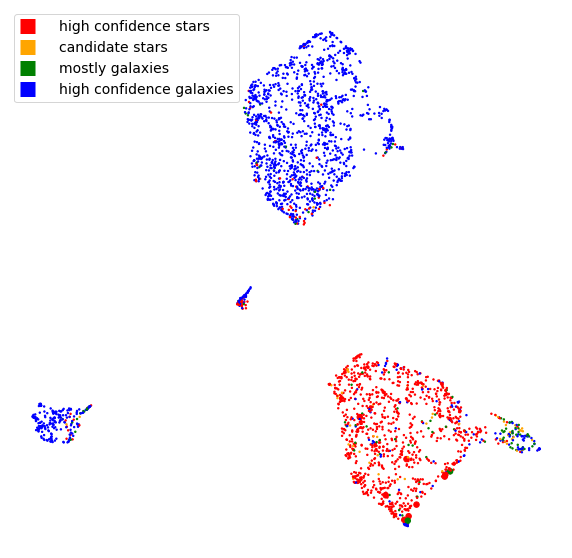

In [ ]:
fg, ax = plt.subplots(figsize=(10,10))
# cMap = mpl.colors.ListedColormap(['red', 'orange', 'green','blue'])
base_cols = ['red','orange','green','blue']
classes = class_df['EXTENDED_CLASS_COADD']
valid = classes!=-9
cols = [base_cols[i] for i in classes[valid]]
ax.scatter(points[valid,0], points[valid,1], c=cols, 
            s=2 + 28*hzq_present[valid])
# sc = ax.scatter(embedding.embedding_[:,0],
#             embedding.embedding_[:,1],
#             c=class_df['EXTENDED_CLASS_COADD'],
#             cmap=cMap,
#             s=10*hzq_present+1,
#             # vmin=19, vmax=23
#             )
cls = [mpl.lines.Line2D([0],[0], color=col, ls=':', lw=15) for col in base_cols]
ax.legend(cls, ['high confidence stars',
                'candidate stars',
                'mostly galaxies',
                'high confidence galaxies'],
        #   loc='upper left',
          fontsize=14
          )
ax.axis('off')

# cb = fg.colorbar(sc)
# cb.ax.set_ylabel('Extended Class', rotation=270, fontsize=20)
# cb.ax.get_yaxis().labelpad = 30

In [ ]:
def plot_embedding(x, y, orig_df=wise_df, col_field='cls'):
    embed_df = orig_df.copy()
    embed_df['x'] = x
    embed_df['y'] = y
    embed_df_copy = embed_df.copy()
    if col_field == 'cls':
        orig_col_nums = class_df['EXTENDED_CLASS_COADD'].to_numpy()
        embed_df['cols'] = [
            ['#ff0000','#ff8800','#00ff00','#0000ff'][cl] for cl in orig_col_nums
            ]
        embed_df['class'] = [
            ['High Confidence Stars',
             'Candidate Stars',
             'Mostly Galaxies',
             'High Confidence Galaxies'][cl] for cl in orig_col_nums
        ]
    else:
        orig_col_nums = embed_df_copy[col_field].to_numpy()
        col_nums = np.copy(orig_col_nums)
        col_nums[col_nums==99.] = np.min(col_nums)
        col_nums -= np.min(col_nums)
        col_nums /= np.max(col_nums)
        embed_df['cols'] = rgba_to_hex(mpl.cm.get_cmap('viridis')(col_nums))

    embed_df['sz'] = hzq_present*10+3

    source = embed_df
    img_tooltip = """
            <img
                    src="https://xbyrne.github.io/images/grizY/@{coadd_object_id}.png" alt="@coadd_object_id"
                    style="float; width:500; height:auto; margin:0 auto;"
            ></img>
        
        <div style='margin:auto; width:100%; text-align: center;'>
            <table style='margin:0 auto;'>
                <tr> <th></th> <th></th> <th> id </th> <th> RA </th> <th> Dec </th> </tr>
                <tr> <td></td> <td></td> <td> @{coadd_object_id} </td> <td> @{ra} </td> <td> @{dec} </td> </tr>
                <tr> <th> g </th> <th> r </th> <th> i </th> <th> z </th> <th> Y </th>
                    <th> W1 </th> <th> W2 </th> </tr>
                <tr> <td> @{mag_aper_4_g} </td> <td> @{mag_aper_4_r} </td> <td> @{mag_aper_4_i} </td> <td> @{mag_aper_4_z} </td>
                    <td> @{mag_aper_4_y} </td> <td> @{mag_w1_vg} </td> <td> @{mag_w2_vg} </td></tr>
            </table>
        </div>
    """
    P = bokeh.plotting.figure(tooltips=img_tooltip,
                              plot_width=1000, plot_height=1000)
    P.circle('x', 'y',
      source=source,
      size='sz',
      color='cols',
      legend_field='class'
      )
    
    P.min_border_left=200
    P.min_border_right=200
    P.min_border_top=100
    P.min_border_bottom=200

    
    if col_field == 'cls':
        P.legend.location = 'top_left'
    else:
        color_mapper = bokeh.models.LinearColorMapper(palette="Viridis256",
                                            low=np.min(orig_col_nums), 
                                            high=np.max(orig_col_nums[
                                                orig_col_nums!=99.
                                            ]))

        color_bar = bokeh.models.ColorBar(color_mapper=color_mapper, label_standoff=12)
        P.add_layout(color_bar, 'right')

    P.axis.visible=False

    bokeh.plotting.output_notebook()
    bokeh.plotting.show(P)


    return P

def rgba_to_hex(rgb_array):
    hex_array = []
    for i, rgba in enumerate(rgb_array):
        hexcol = '#%02x%02x%02x' % (int(rgba[0]*255), int(rgba[1]*255), int(rgba[2]*255))
        hex_array.append(hexcol)
    return np.array(hex_array)

In [ ]:
P = plot_embedding(points[:,0],
                    points[:,1],
                    # col_field='mag_aper_4_g'
                    )

In [ ]:
html = bokeh.embed.file_html(P, bokeh.resources.CDN, 'bokeh_plot')
with open('bokeh_file.html', 'w') as f:
    f.write(html)

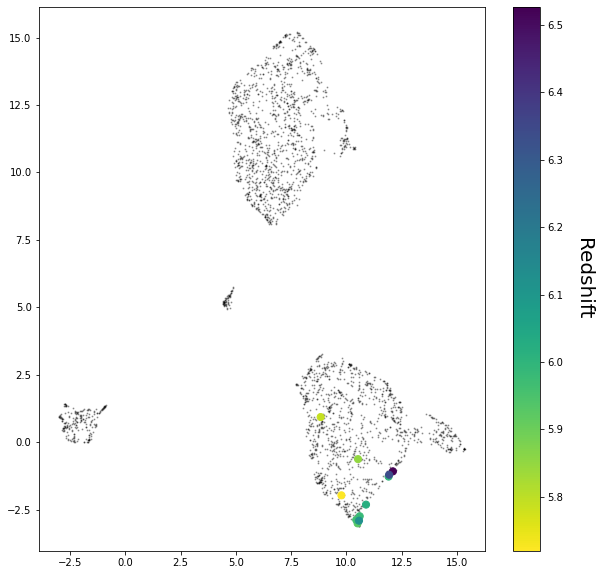

In [ ]:
fg, ax = plt.subplots(figsize=(10,10))

ax.scatter(points[hzq_present==False,0],
           points[hzq_present==False,1], c='k', alpha=.3, s=1)

sc = ax.scatter(points[hzq_present,0],
           points[hzq_present,1], 
           c=hzq_df.loc[ids[hzq_present],'redshift'], cmap='viridis_r',
           s=50)
cb = fg.colorbar(sc)
cb.ax.set_ylabel('Redshift', rotation=270, fontsize=20)
cb.ax.get_yaxis().labelpad = 30

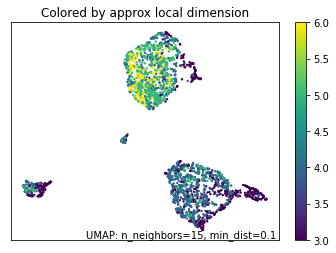

In [ ]:
umap.plot.diagnostic(embedding, diagnostic_type='local_dim')

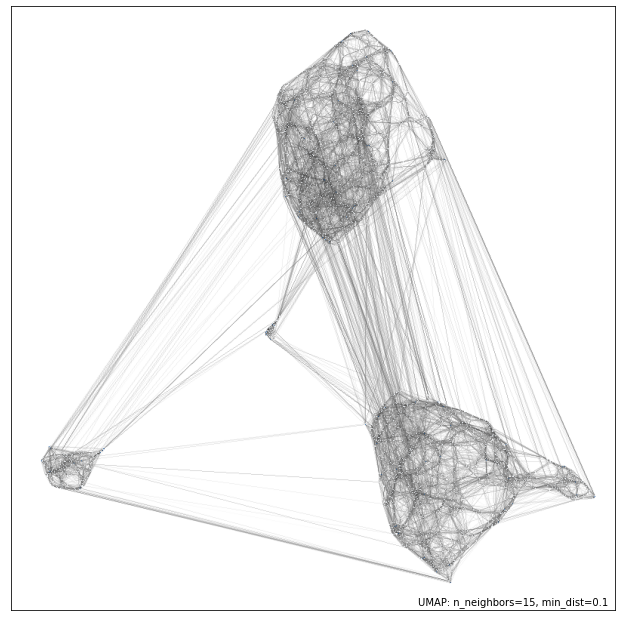

In [ ]:
umap.plot.connectivity(embedding, show_points=True)

In [ ]:
html = bokeh.embed.file_html(P, bokeh.resources.CDN, 'bokeh_html')
with open('./gdrive/MyDrive/MPIA/Contrastive/bokeh_html_27.html', 'w') as f:
    f.write(html)

## Saving Model
(i.e. just the encoder)

In [ ]:
grizY_contr.encoder.save('./gdrive/MyDrive/MPIA/Contrastive/contr_rn_0027')

In [ ]:
np.savez_compressed('./gdrive/MyDrive/MPIA/Contrastive/embedding_rn0027.npz',
                    points = embedding.embedding_,
                    ids=ids)